# Using DIPZ

In [66]:
"""
Using dipz with keras
"""
#'Take only this many inputs (with no args %(const)s)'
_h_take_first = 'Take only this many inputs (with no args %(const)s)'  

# TODO: clean up these hardcoded values
MASK_VALUE = 999
MERGED_NODES = [32]*4

# local libs
from layers import Sum
from utils import gaussian_loss
from utils import TRANSFORMS
from utils import scale
from utils import renamed
from utils import build_feature
from utils import get_gaussian_loss_prec

# mlearnin libs
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, TimeDistributed, Input, Concatenate, Masking
)
from keras.utils.generic_utils import CustomMaskWarning

# the data libs
import h5py
import json

# random python utility libs
from argparse import ArgumentParser
from pathlib import Path
import warnings

# A function to define and gets the config file 
def get_config(config_path):
    with open(config_path) as cfg:
        config = json.load(cfg)
    return dict(
        jetfeatnames=config["jetfeatnames"],
        trackfeatnames=config["trackfeatnames"],
        targetfeatnames=config["targetfeatnames"],
        batch_size=config["batch_size"],
        epoch_size=config["epoch_size"],
        number_epochs=config["number_epochs"],
        learning_rate=config["lr"],
        tracknodes=config['tracknodes'],
        jetnodes=config['jetnodes'],
    )

# A function that defines and gets the neural network model
def get_model(config, mask_value):
    n_track_inputs = len(config['trackfeatnames'])
    track_inputs = Input(shape=(None,n_track_inputs))

    n_jet_inputs = len(config['jetfeatnames'])
    jet_inputs = Input(shape=(n_jet_inputs))

    # add jet layers
    x = jet_inputs
    for nodes in config['jetnodes']:
        x = Dense(units=nodes, activation='relu')(x)
    jet_latent = x

    # add track layers
    x = track_inputs
    x = Masking(mask_value=mask_value)(x)
    for nodes in config['tracknodes']:
        x = TimeDistributed(Dense(nodes, activation='relu'))(x)
    x = Sum()(x)
    track_latent = x

    # merge the layers
    merged = Concatenate()([jet_latent, track_latent])
    # todo: not clear how many additonal processing layers we should
    # add here
    x = merged
    for nodes in MERGED_NODES:
        x = Dense(nodes, activation='relu')(x)
    out_latent = x
    outputs = keras.layers.Dense(units=2)(out_latent)
    model = keras.Model(
        inputs=[jet_inputs, track_inputs],
        outputs=outputs)
    # print the summary
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=gaussian_loss)
    return model

# A function that imports the dataset we will be working on
def get_dataset(h5file_path, config, mask_value, take_first=False):
    """
    We make some hardcoded transformations to normalize these inputs
    """

    # pt is log transformed
    # Z0 is divided by 50
    # target is divided by 50

    trf = TRANSFORMS
    # identy function to pass through things that aren't listed above
    def ident(x):
        return x

    sl = slice(None,None,None)
    if take_first:
        sl = slice(0,take_first,None)

    with h5py.File(h5file_path) as h5file:
        # get track array
        td = h5file['super_tracks']
        tfn = config['trackfeatnames']
        # we can pass through NaNs here
        with np.errstate(invalid='ignore'):
            trackstack = [trf.get(x,ident)(td[x,sl,...]) for x in tfn]
        track_array = np.stack(trackstack, axis=2)
        invalid = np.isnan(td['pt',sl])
        track_array[invalid,:] = mask_value

        # get jet array
        jd = h5file['jets']
        jfn = config['jetfeatnames']
        jetstack = [trf.get(x,ident)(jd[x,sl]) for x in jfn]
        jet_array = np.stack(jetstack, axis=1)

        # get targets
        tfn = config['targetfeatnames']
        targetstack = [trf.get(x,ident)(jd[x,sl]) for x in tfn]
        target_array = np.stack(targetstack, axis=1)

    return jet_array, track_array, target_array


# A function that predicts the output, produces target arrays and returns them
def dump_prediction(model, jet_inputs, track_inputs, targets):
    pred = model.predict([jet_inputs, track_inputs])
    z = pred[:,0]
    zhat = targets[:,0]
    widths = np.sqrt(np.exp(-pred[:,1])) #Standard Deviation
    sigma = (z - zhat) / widths
    print(np.stack([z, zhat, widths, sigma]).T[:20])
    return z, zhat, widths, sigma

# A function that gets the config file, model, dataset, inputs weights to the model, 
#makes predictions and saves them
def run(z, zhat, widths, sigma):
    mask_value = MASK_VALUE
    config = get_config("./regress.json")
    model = get_model(config, mask_value=mask_value)
    model.load_weights('outputs/weights.h5')
    jet_inputs, track_inputs, targets = get_dataset(
    "../user.maboelel.32438279._000005.output.h5", config, mask_value)
    z, zhat, widths, sigma = dump_prediction(model, jet_inputs, track_inputs, targets)
    return z, zhat, widths, sigma

In [67]:
# Defining our containers for the output results
z, zhat, widths, sigma = [], [], [], []

In [68]:
z, zhat, widths, sigma = run(z, zhat, widths, sigma)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 8)]    0           []                               
                                                                                                  
 masking_1 (Masking)            (None, None, 8)      0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, None, 16)    144         ['masking_1[0][0]']              
 buted)                                                                                     

In [69]:
z

array([ 1.2918596 ,  1.317312  ,  0.2501318 , ..., -0.866961  ,
       -0.03780727,  0.04239094], dtype=float32)

107368


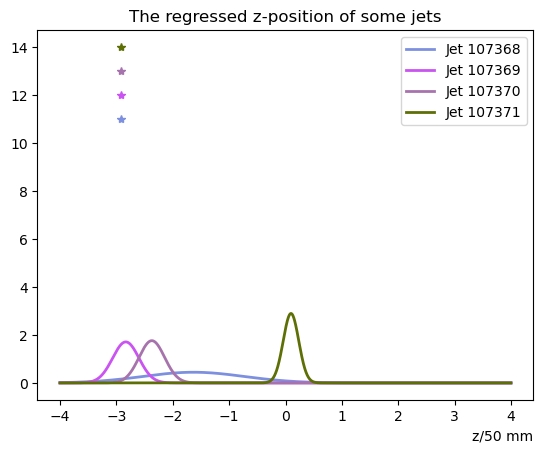

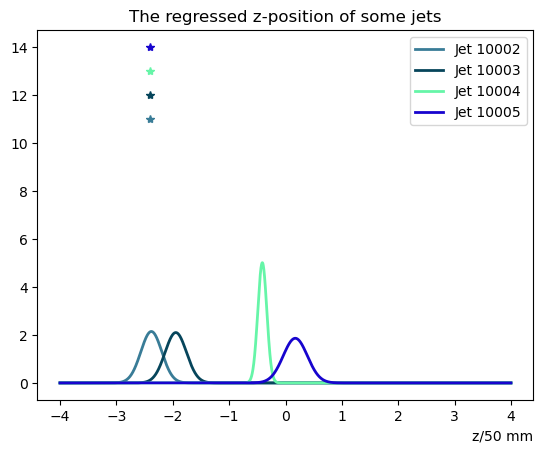

In [70]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

#Finding the events with 4 jets
uniques = np.unique(zhat)
c = 0
values = []
for value in uniques:
    if len(zhat[zhat == value]) == 4:
        values.append(value)

print(np.where(zhat == values[0])[0][0])

#Plotting some events with 4 jets
for i in range(2): 
    x = np.arange(-4, 4, 0.001)
    ind_of_first = np.where(zhat == values[i])[0][0]
    n = np.arange(ind_of_first,ind_of_first+4,1)
    #Generating random colors for the plot
    color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(len(n))]
    ic = 0      #color counter

    for i in n:
        plt.plot(x, norm.pdf(x, z[i], widths[i]), color=color[ic], linewidth=2, label='Jet '+str(i))
        plt.plot(zhat[i], 11 + ic, marker='*', color=color[ic])
        ic = ic + 1
    plt.xlabel("z/50 mm", loc='right')
    plt.title('The regressed z-position of some jets')
    plt.legend()
    plt.show()
    #plt.cla()

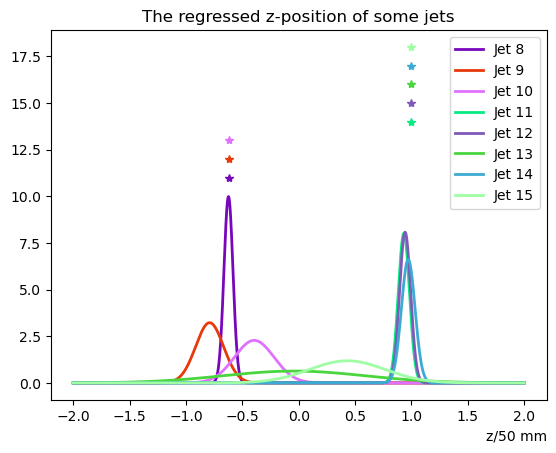

In [71]:
'''Plotting the jets' regressed z-position'''
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import random


#z-axis ranges from -2 and 2 with .001 steps
x = np.arange(-2, 2, 0.00001)
n = np.arange(8,16,1)

#Generating random colors for the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
       for j in range(len(n))]
ic = 0      #color counter

for i in n:
    plt.plot(x, norm.pdf(x, z[i], widths[i]), color=color[ic], linewidth=2, label='Jet '+str(i))
    plt.plot(zhat[i], 11 + ic, marker='*', color=color[ic])
    ic = ic + 1
    """plt.plot(x, norm.pdf(x, z[6], widths[6]), color='red', linewidth=2, label='Second Jet')
    plt.plot(zhat[6], 11, marker='*', color="red")
    plt.plot(x, norm.pdf(x, z[7], widths[7]), color='green', linewidth=2, label='Third Jet')
    plt.plot(zhat[7], 12, marker='*', color="green")
    plt.plot(x, norm.pdf(x, z[8], widths[8]), color='orange', linewidth=2, label='Fourth Jet')
    plt.plot(zhat[8], 13, marker='*', color="orange")
    plt.plot(x, norm.pdf(x, z[9], widths[9]), color='purple', linewidth=2, label='Fifth Jet')
    plt.plot(zhat[9], 14, marker='*', color="purple")
    """
plt.xlabel("z/50 mm", loc='right')
plt.title('The regressed z-position of some jets')
plt.legend()
plt.show()
#plt.cla()

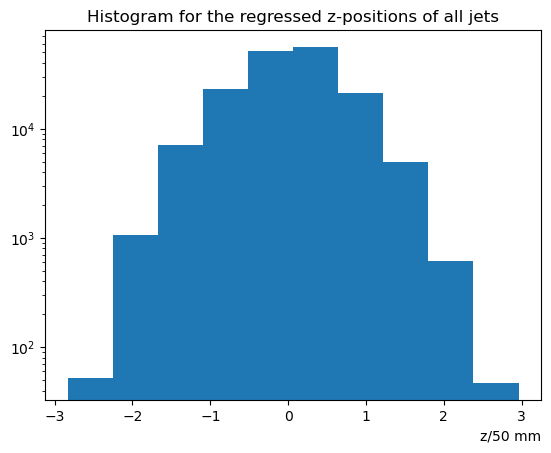

In [72]:
"""Plotting a histogram of the regressed z-positions of all jets"""
plt.hist(z, bins=10)
plt.yscale("log")
plt.title('Histogram for the '+ 'regressed z-positions' +' of all jets')
plt.xlabel("z/50 mm", loc='right')
plt.show()

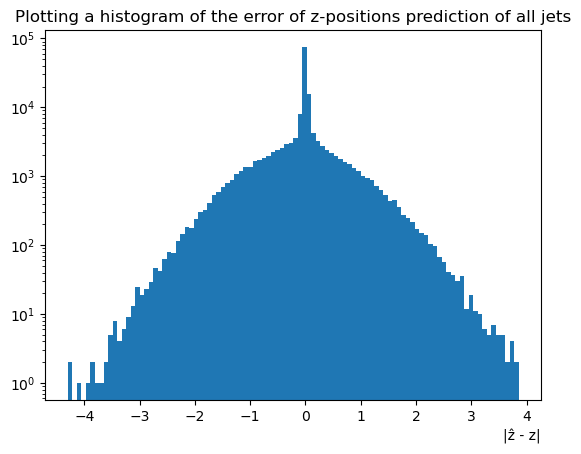

In [73]:
"""Plotting a histogram of the error of z-positions prediction of all jets"""
plt.hist(zhat-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of z-positions prediction of all jets')
plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

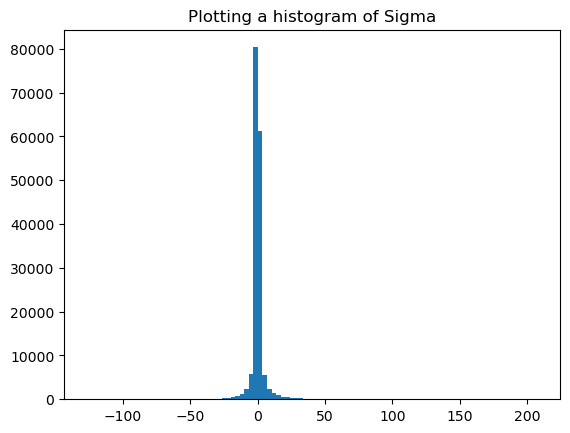

In [74]:
plt.hist(sigma, bins=100)
#plt.yscale('log')
plt.title('Plotting a histogram of Sigma')
plt.xlabel("", loc='right')
plt.show()

In [75]:
print(np.std(sigma))

5.712322


# Accessing the Dataset

In [76]:
from turtle import title
from h5py import File
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

In [77]:
#Opening the HDF5 File
input_file = "../user.maboelel.32438279._000005.output.h5"
data = File(input_file, 'r')

In [78]:
#Accessing the 'Jets' Dataset
print("List of available datasets: " + str(list(data.keys())))
jets = data['jets']

List of available datasets: ['jets', 'super_tracks', 'super_tracks_associated', 'super_tracks_fixed_cone']


In [79]:
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))

The attributes of each element of the dataset (jets): dict_keys(['pt', 'HadronConeExclTruthLabelPt', 'n_tracks_nn', 'eta', 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'dipz_z', 'dipz_negLogSigma2', 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 'n_super_tracks', 'n_super_tracks_associated', 'n_super_tracks_fixed_cone', 'mcEventWeight', 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 'nPrimaryVertices', 'primaryVertexDetectorZ', 'primaryVertexDetectorZUncertainty'])


In [80]:
print(jets[jets['eventNumber'] == 1856003]['eventNumber'])

[]


In [81]:
print(jets['eventNumber'])

[4835583 4835583 4835583 ... 3692988 3692988 3692988]


In [82]:
super_tracks = data['super_tracks']
print("The attributes of each element of the dataset (super_tracks): " + str(super_tracks.dtype.fields.keys()))

The attributes of each element of the dataset (super_tracks): dict_keys(['numberOfInnermostPixelLayerHits', 'numberOfNextToInnermostPixelLayerHits', 'numberOfPixelHits', 'numberOfSCTHits', 'numberOfPixelHoles', 'numberOfSCTHoles', 'chiSquared', 'numberDoF', 'radiusOfFirstHit', 'qOverP', 'pt', 'qOverPUncertainty', 'd0', 'd0Uncertainty', 'IP2D_signed_d0', 'phiUncertainty', 'thetaUncertainty', 'deta', 'dphi', 'dr', 'ptfrac', 'z0RelativeToBeamspot', 'z0RelativeToBeamspotUncertainty', 'valid'])


In [83]:
print(super_tracks['z0RelativeToBeamspot'])

[[ 10.32  63.62  63.38 ...    nan    nan    nan]
 [ 45.84  20.1   63.6  ...    nan    nan    nan]
 [ 10.41  10.41 -17.02 ...    nan    nan    nan]
 ...
 [-72.8  -92.9  105.56 ...    nan    nan    nan]
 [ -9.51 -17.94 -87.94 ...    nan    nan    nan]
 [ -6.66 -75.75  95.94 ...    nan    nan    nan]]


In [84]:
print(np.sum(jets['n_super_tracks'] > 40))

65


In [85]:
print(len(jets))

165789


In [86]:
print(z.shape)

(165789,)


In [87]:
print(jets)

<HDF5 dataset "jets": shape (165789,), type "|V70">


In [88]:
print(z[0])

1.2918596


In [89]:
print(jets['dipz_z'][0])

1.292


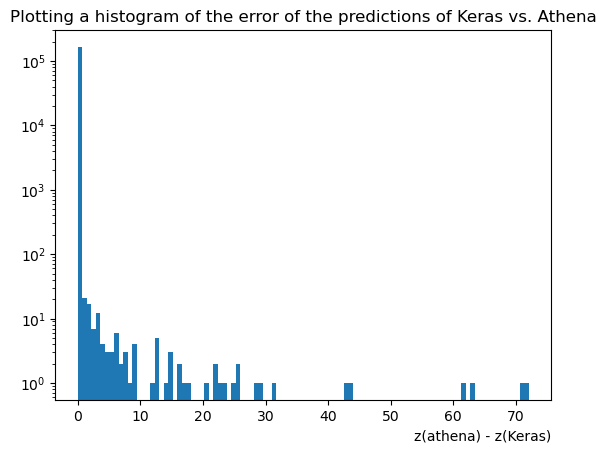

In [90]:
plt.hist(np.abs(jets['dipz_z']-z) * 50, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

2


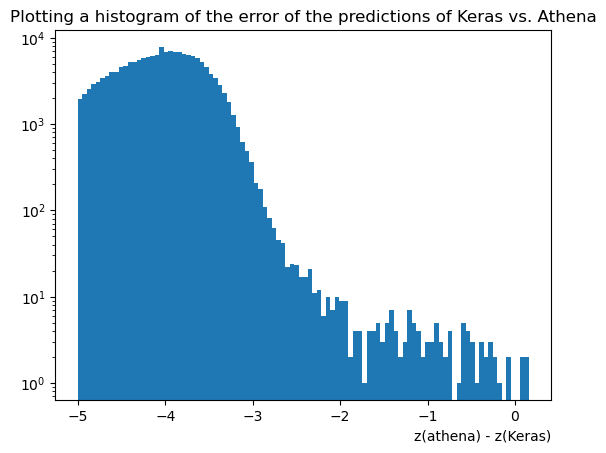

In [91]:
سين = 2
print(سين)
plt.hist(np.log10(np.abs(jets['dipz_z']-z) + 10**-5), bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

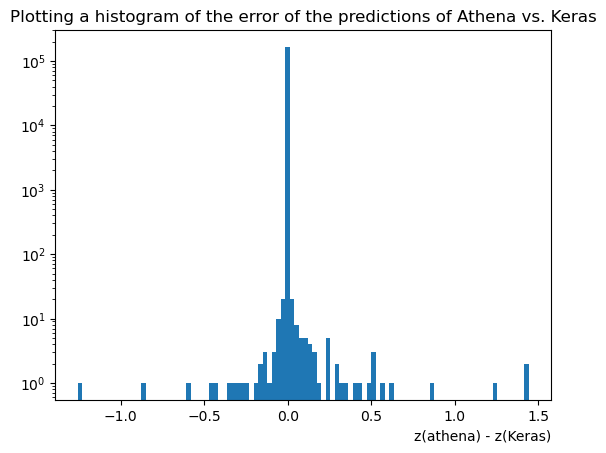

In [92]:
c1 = jets['dipz_z']-z
plt.hist(c1, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Athena vs. Keras')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

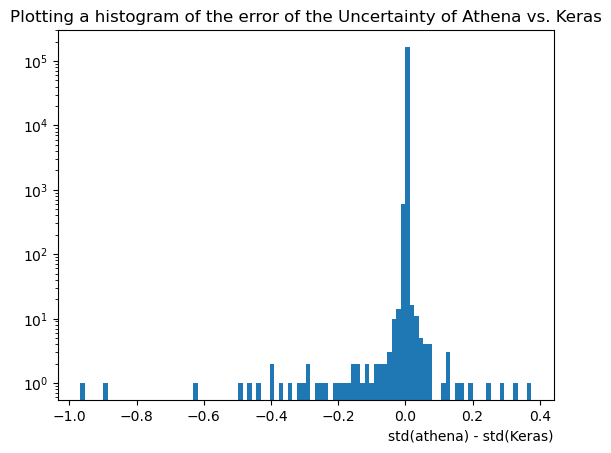

In [93]:
c2 = np.sqrt(np.exp(-jets['dipz_negLogSigma2']))-widths
plt.hist(c2, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the Uncertainty of Athena vs. Keras')
plt.xlabel("std(athena) - std(Keras)", loc='right')
plt.show()

In [94]:
jets['dipz_z'].dtype

dtype('<f2')

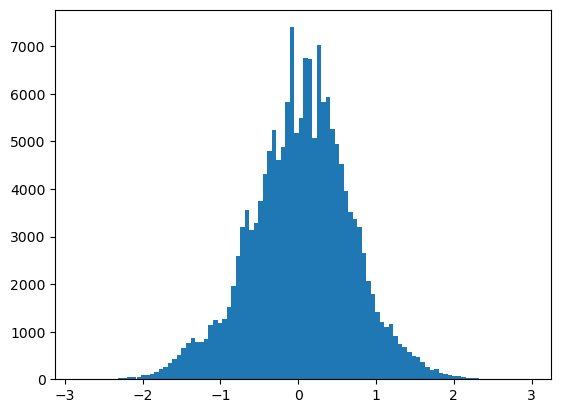

In [95]:
plt.hist(jets['dipz_z'], bins=100)
#plt.yscale('log')
plt.show()

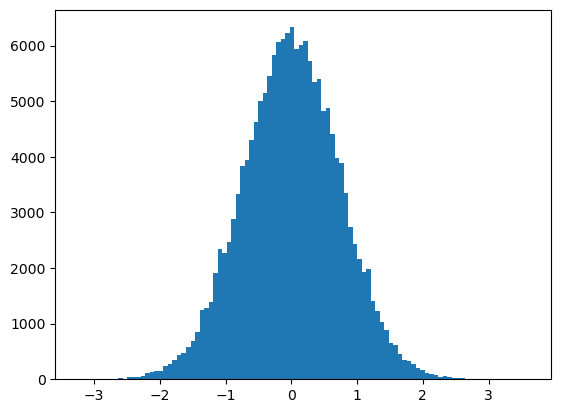

In [96]:
plt.hist(zhat, bins=100)
#plt.yscale('log')
plt.show()

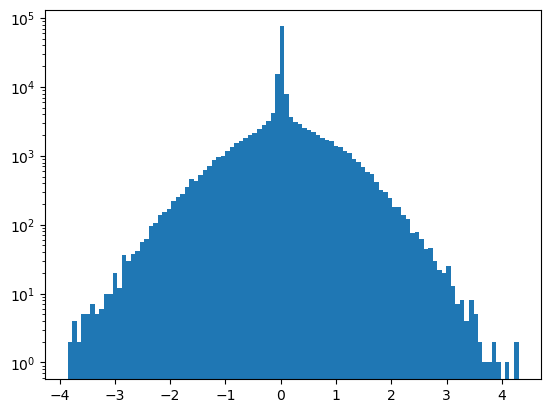

In [97]:
plt.hist(jets['dipz_z']-zhat, bins=100)
plt.yscale('log')
plt.show()

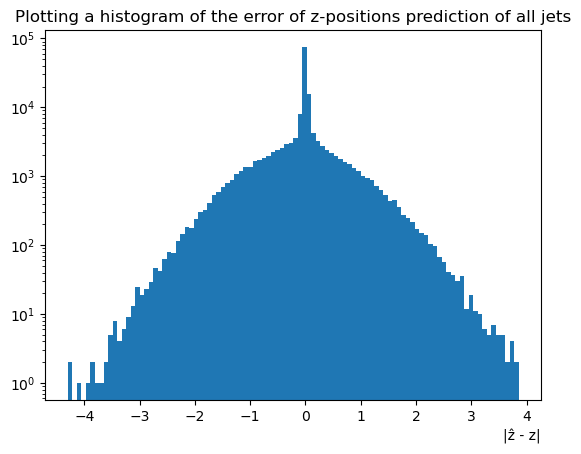

In [98]:
"""Plotting a histogram of the error of z-positions predictionof all jets"""
plt.hist(zhat-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of z-positions prediction of all jets')
plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

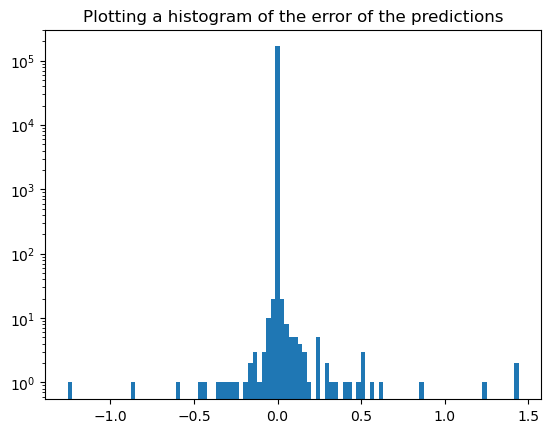

In [99]:
plt.hist(jets['dipz_z']-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions')
#plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

In [100]:
print(jets["n_tracks_nn"])
print(jets["n_super_tracks"])

[13.  7.  4. ... 19. 16. 20.]
[13  7  4 ... 19 16 20]


In [101]:
x = jets["n_tracks_nn"] == jets["n_super_tracks"]
print(False in x)

False


In [102]:
d = jets['dipz_z']-z
c = d > 0.01 
print(len(d))
print(np.count_nonzero(c))

165789
76


In [103]:
regions = [10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9,10**-10]
for i in regions:
    c = c1 > i 
    n = np.count_nonzero(c)
    print("The number of predictions with error in calculating z bigger than " + str(i) + " is " + str(n))

The number of predictions with error in calculating z bigger than 0.01 is 76
The number of predictions with error in calculating z bigger than 0.001 is 571
The number of predictions with error in calculating z bigger than 0.0001 is 36418
The number of predictions with error in calculating z bigger than 1e-05 is 74580
The number of predictions with error in calculating z bigger than 1e-06 is 81499
The number of predictions with error in calculating z bigger than 1e-07 is 82184
The number of predictions with error in calculating z bigger than 1e-08 is 82246
The number of predictions with error in calculating z bigger than 1e-09 is 82246
The number of predictions with error in calculating z bigger than 1e-10 is 82246


In [104]:
regions = [10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9,10**-10]
for i in regions:
    c = c2 > i 
    n = np.count_nonzero(c)
    print("The number of predictions with error in calculating z_deviations bigger than " + str(i) + " is " + str(n))

The number of predictions with error in calculating z_deviations bigger than 0.01 is 58
The number of predictions with error in calculating z_deviations bigger than 0.001 is 291
The number of predictions with error in calculating z_deviations bigger than 0.0001 is 18657
The number of predictions with error in calculating z_deviations bigger than 1e-05 is 69332
The number of predictions with error in calculating z_deviations bigger than 1e-06 is 81845
The number of predictions with error in calculating z_deviations bigger than 1e-07 is 83079
The number of predictions with error in calculating z_deviations bigger than 1e-08 is 83196
The number of predictions with error in calculating z_deviations bigger than 1e-09 is 83210
The number of predictions with error in calculating z_deviations bigger than 1e-10 is 83210


In [105]:
s = jets['dipz_negLogSigma2']-widths
max = np.argmax(s)

In [106]:
jet_intended = jets[max]
jet_variables = ['pt', 'HadronConeExclTruthLabelPt', 'n_tracks_nn', 'eta', 
                 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'dipz_z', 'dipz_negLogSigma2', 
                 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 
                 'n_super_tracks', 'n_super_tracks_associated', 'n_super_tracks_fixed_cone', 'mcEventWeight', 
                 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 
                 'nPrimaryVertices', 'primaryVertexDetectorZ', 'primaryVertexDetectorZUncertainty']
for var in jet_variables:
    c = jet_intended[var]
    print("The jet's " + var + " is " + str(c))

The jet's pt is 79031.734
The jet's HadronConeExclTruthLabelPt is nan
The jet's n_tracks_nn is 17.0
The jet's eta is -0.648
The jet's fastDips_pb is 0.1956
The jet's fastDips_pc is 0.3394
The jet's fastDips_pu is 0.465
The jet's dipz_z is -0.2472
The jet's dipz_negLogSigma2 is 9.72
The jet's HadronConeExclTruthLabelID is 0
The jet's HadronConeExclExtendedTruthLabelID is 0
The jet's jetPtRank is 0
The jet's n_super_tracks is 17
The jet's n_super_tracks_associated is 17
The jet's n_super_tracks_fixed_cone is 18
The jet's mcEventWeight is 9.334e-05
The jet's eventNumber is 3661243
The jet's averageInteractionsPerCrossing is 45.5
The jet's actualInteractionsPerCrossing is 45.5
The jet's nPrimaryVertices is 15
The jet's primaryVertexDetectorZ is -12.23
The jet's primaryVertexDetectorZUncertainty is 0.01747


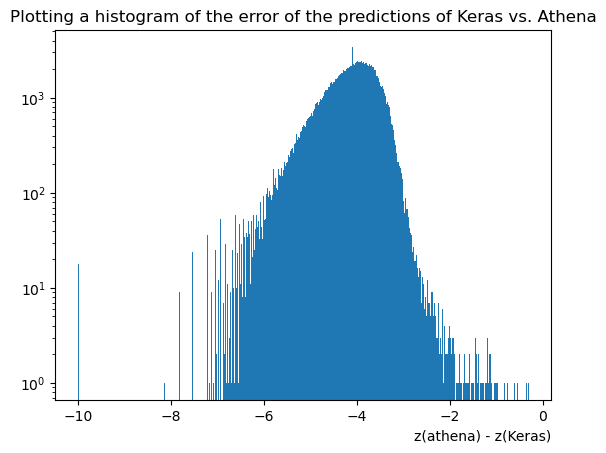

In [107]:
idx = jets['n_super_tracks'] < 40
c = jets['dipz_z']-z
plt.hist(np.log10(np.abs(c[idx])+ 1e-10) , bins=500)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

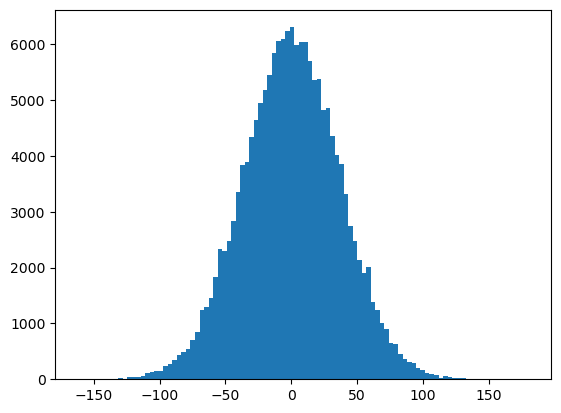

In [108]:
plt.hist(jets['primaryVertexDetectorZ'], bins=100)
#plt.yscale('log')
plt.show()

In [109]:
j = jets['primaryVertexDetectorZ'].astype('float64')
print("The target's mean is: " + str(j.mean()))
print("The target's std is: " + str(j.std()))

The target's mean is: 0.08465870821568523
The target's std is: 36.759296424574785
